Total students: 1000
MAE: 10.78356
RMSE: 13.648773807358829


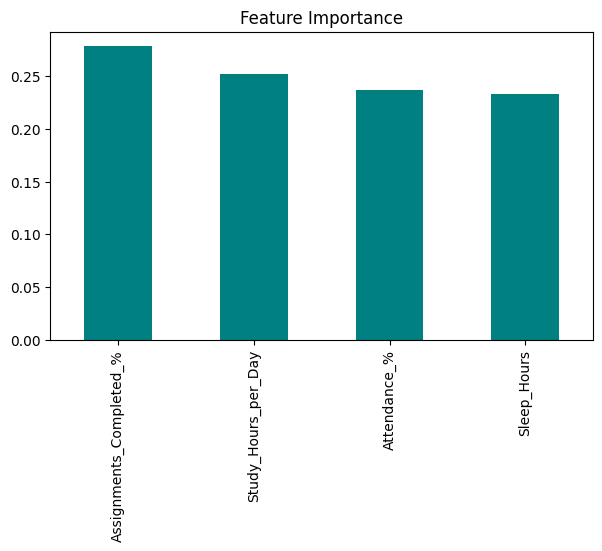

/tmp/ipython-input-3862923131.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Level', data=df_original, palette='rocket')


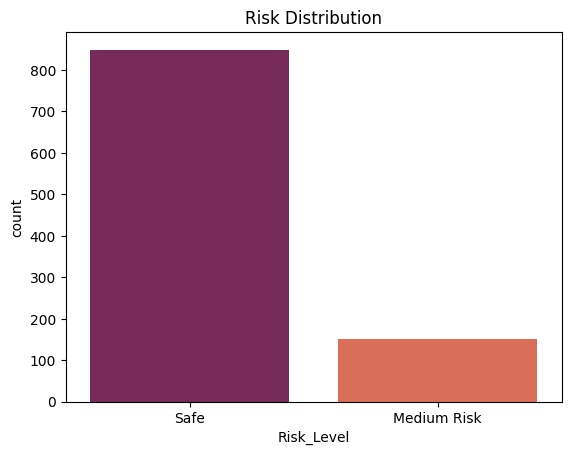

/tmp/ipython-input-3862923131.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Weak_Subject', data=df_original, palette='viridis')


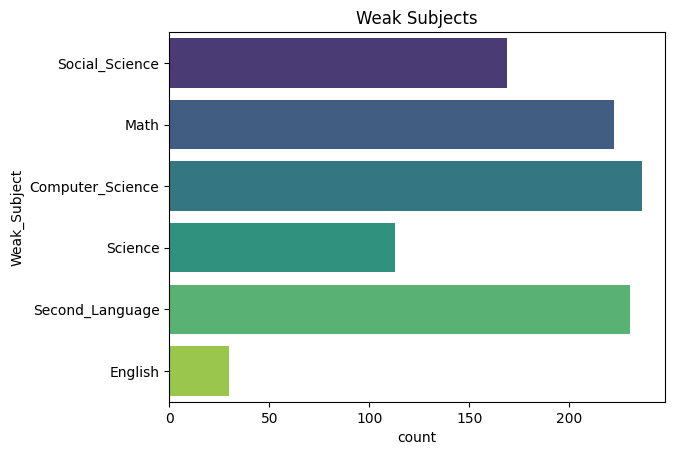

gender                                                            female
Attendance_%                                                          72
Study_Hours_per_Day                                                  4.2
Final_Grade                                                           75
Predicted_Grade                                                71.666667
Risk_Level                                                          Safe
Weak_Subject                                                        Math
Learning_Style                                        Consistent Learner
Learning_Path                             Improve attendance consistency
Predicted_Grade_If_Attendance_Improves                         67.777606
Name: 5, dtype: object


In [3]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

# LOAD DATA
df_original = pd.read_csv("high_school_students_grade_prediction.csv")
df_ml = df_original.copy()

print("Total students:", len(df_original))

# ENCODING (ML ONLY)
cat_cols = df_ml.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col])

# FEATURE SETS
subjects = [
    'Math', 'English', 'Science',
    'Social_Science', 'Computer_Science', 'Second_Language'
]

behavior_features = [
    'Attendance_%',
    'Study_Hours_per_Day',
    'Assignments_Completed_%',
    'Sleep_Hours'
]

# EARLY-STAGE MODEL
X_early = df_ml[behavior_features]
y = df_ml['Final_Grade']

X_train, X_test, y_train, y_test = train_test_split(
    X_early, y, test_size=0.25, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=300, random_state=42
)
rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

# STUDENT-WISE PREDICTION
df_original['Predicted_Grade'] = rf_model.predict(X_early)

# EXPLAINABLE AI
importance = pd.Series(
    rf_model.feature_importances_,
    index=behavior_features
).sort_values(ascending=False)

importance.plot(kind='bar', figsize=(7,4), color='teal')
plt.title("Feature Importance")
plt.show()

# AT-RISK DETECTION
def risk_level(g):
    if g < 40:
        return "High Risk"
    elif g < 60:
        return "Medium Risk"
    return "Safe"

df_original['Risk_Level'] = df_original['Predicted_Grade'].apply(risk_level)

sns.countplot(x='Risk_Level', data=df_original, palette='rocket')
plt.title("Risk Distribution")
plt.show()

# SUBJECT WEAKNESS
df_original['Weak_Subject'] = df_original[subjects].idxmin(axis=1)

sns.countplot(y='Weak_Subject', data=df_original, palette='viridis')
plt.title("Weak Subjects")
plt.show()

# LEARNING STYLE CLUSTERING
cluster_features = [
    'Study_Hours_per_Day',
    'Attendance_%',
    'Sleep_Hours'
]

scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_ml[cluster_features])

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

style_map = {
    0: "Consistent Learner",
    1: "Last-Minute Learner",
    2: "Balanced Learner"
}

df_original['Learning_Style'] = pd.Series(clusters).map(style_map)

# PERSONALIZED LEARNING PATH
def learning_path(row):
    if row['Risk_Level'] == "High Risk":
        return f"Urgent academic support needed in {row['Weak_Subject']}"
    if row['Study_Hours_per_Day'] < 2:
        return "Increase study hours to at least 3 per day"
    if row['Attendance_%'] < 75:
        return "Improve attendance consistency"
    if row['Assignments_Completed_%'] < 70:
        return "Complete assignments regularly"
    return "Maintain current learning strategy"

df_original['Learning_Path'] = df_original.apply(learning_path, axis=1)

# WHAT-IF ANALYSIS (FIXED)
lr = LinearRegression()
lr.fit(X_early, y)

X_whatif = X_early.copy()
X_whatif['Attendance_%'] = np.clip(
    X_whatif['Attendance_%'] + 10, 0, 100
)

df_original['Predicted_Grade_If_Attendance_Improves'] = lr.predict(X_whatif)

# SINGLE STUDENT VIEW
student_id = 5
print(df_original.loc[student_id, [
    'gender',
    'Attendance_%',
    'Study_Hours_per_Day',
    'Final_Grade',
    'Predicted_Grade',
    'Risk_Level',
    'Weak_Subject',
    'Learning_Style',
    'Learning_Path',
    'Predicted_Grade_If_Attendance_Improves'
]])

df_original.to_csv(
    "final_student_performance.csv",
    index=False
)
